In [3]:
!pip install praw 
!pip install yfinance

In [4]:
!pip install transformers

In [5]:
!pip install seaborn #why arent basic libraries installed by default???

In [6]:
#author == Harsh-Thorat
"""
Ok, so lets do Stock Sentiment Analysis with FinBERT
A comprehensive sentiment analysis system for r/wallstreetbets posts from Reddit.
I honestly have no idea what i am doing so please forgive me
"""

import pandas as pd
import numpy as np
import praw
import yfinance as yf
from datetime import datetime, timedelta
import re
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm import tqdm
import warnings
import pickle
from typing import List, Dict, Tuple
import logging
from scipy import stats

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [7]:
# Configuration
# Dont expect to see the client secret, you wont catch me slipping
class Config:
    """Configuration settings for the sentiment analyzer"""
    # Reddit API credentials (need to fill these in)
    REDDIT_CLIENT_ID = "NaN"
    REDDIT_CLIENT_SECRET = "Nan"
    REDDIT_USER_AGENT = "WSB_Sentiment_Analyzer/1.0"
    
    # Model 
    MODEL_NAME = "ProsusAI/finbert"
    BATCH_SIZE = 32
    MAX_LENGTH = 512
    
    # Data collection
    SUBREDDIT = "wallstreetbets"
    POST_LIMIT = 500  # Per collection run
    
    
    SENTIMENT_THRESHOLD = 0.7  # Confidence threshold for sentiment classification

In [8]:
class RedditDataCollector:
    """To collect and preprocesses data from r/wallstreetbets"""
    
    def __init__(self, client_id: str, client_secret: str, user_agent: str):
        """Initialize Reddit API connection"""
        self.reddit = praw.Reddit(
            client_id=client_id,
            client_secret=client_secret,
            user_agent=user_agent
        )
        self.subreddit = self.reddit.subreddit(Config.SUBREDDIT)
        
    def collect_posts(self, limit: int = 500, time_filter: str = 'day') -> pd.DataFrame:
        """
        Collect posts from r/wallstreetbets
        
        Args:
            limit: Number of posts to collect
            time_filter: Time filter for posts ('day', 'week', 'month', 'year', 'all')
        
        Returns:
            DataFrame with post data
        """
        posts_data = []
        
        logger.info(f"Collecting {limit} posts from r/{Config.SUBREDDIT}...")
        
        # Collect from different categories for diversity
        categories = {
            'hot': self.subreddit.hot(limit=limit//4),
            'new': self.subreddit.new(limit=limit//4),
            'top': self.subreddit.top(time_filter=time_filter, limit=limit//4),
            'rising': self.subreddit.rising(limit=limit//4)
        }
        
        for category, posts in categories.items():
            for post in tqdm(posts, desc=f"Collecting {category} posts"):
                # Skip deleted/removed posts
                if post.selftext in ['[deleted]', '[removed]', '']:
                    continue
                    
                posts_data.append({
                    'id': post.id,
                    'title': post.title,
                    'body': post.selftext,
                    'score': post.score,
                    'upvote_ratio': post.upvote_ratio,
                    'num_comments': post.num_comments,
                    'created_utc': datetime.fromtimestamp(post.created_utc),
                    'author': str(post.author) if post.author else '[deleted]',
                    'url': post.url,
                    'category': category
                })
        
        df = pd.DataFrame(posts_data)
        logger.info(f"Collected {len(df)} valid posts")
        return df
    def extract_tickers(self, text: str) -> List[str]:
        """
        Extract stock tickers from text
        
        Args:
            text: Input text
        
        Returns:
            List of detected tickers
        """
        # Common WSB tickers and patterns
        ticker_pattern = r'\b[A-Z]{1,5}\b'
        
        # Common false positives to exclude
        exclude_words = {'THE', 'A', 'I', 'AND', 'OR', 'NOT', 'WSB', 'DD', 
                        'YOLO', 'FOMO', 'ATH', 'USD', 'CEO', 'IPO', 'ETF'}
        
        tickers = re.findall(ticker_pattern, text)
        tickers = [t for t in tickers if t not in exclude_words and len(t) >= 2]
        
        return list(set(tickers))
#i'll admit following is a blatant copy from @shahnawazsyed
    def preprocess_wsb_text(self, text: str) -> str:
        """
        Preprocess WSB-specific text patterns
        
        Args:
            text: Raw text from WSB
        
        Returns:
            Cleaned text
        """
        if pd.isna(text):
            return ""
        
        # Convert to string
        text = str(text)
        
        # Handle WSB-specific patterns
        text = re.sub(r'🚀+', ' bullish ', text)  # Rocket emojis = bullish
        text = re.sub(r'💎+\s*👐+', ' diamond hands ', text)  # Diamond hands
        text = re.sub(r'🌈+\s*🐻+', ' bearish ', text)  # Rainbow bear = bearish
        text = re.sub(r'\$([A-Z]{1,5})\b', r'\1', text)  # Remove $ from tickers
        
        # Handle positions format (e.g., "GME 420c 4/20")
        text = re.sub(r'([A-Z]{1,5})\s+\d+[cp]\s+\d+/\d+', r'\1 position', text)
        
        # Common WSB terms
        wsb_terms = {
            r'\bapes?\b': 'investor',
            r'\bretards?\b': 'trader',
            r'\bautist(ic)?\b': 'analytical',
            r'\btendies\b': 'profits',
            r'\bguh\b': 'loss',
            r'\bbrrrr?\b': 'money printing',
            r'\bputs?\b': 'bearish position',
            r'\bcalls?\b': 'bullish position',
            r'\bFD\b': 'risky options',
            r'\bDD\b': 'due diligence',
            r'\bYOLO\b': 'high risk trade',
            r'\bFOMO\b': 'fear of missing out',
            r'\bbagholder\b': 'losing position holder'
        }
        
        for pattern, replacement in wsb_terms.items():
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
        
        # Remove URLs
        text = re.sub(r'http[s]?://\S+', '', text)
        
        # Remove excessive whitespace
        text = ' '.join(text.split())
        
        return text    

In [9]:
class FinBERTSentimentAnalyzer:
    """FinBERT-based sentiment analyzer for financial text"""
    
    def __init__(self):
        """Initialize FinBERT model and tokenizer"""
        logger.info("Loading FinBERT model...")
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)
        self.model = AutoModelForSequenceClassification.from_pretrained(Config.MODEL_NAME)
        self.model.to(self.device)
        self.model.eval()
        logger.info(f"Model loaded on {self.device}")
        
        # Sentiment labels
        self.labels = ['negative', 'neutral', 'positive']
        self.label_map = {'negative': 'Bearish', 'neutral': 'Neutral', 'positive': 'Bullish'}
    
    def analyze_batch(self, texts: List[str]) -> List[Dict]:
        """
        Analyze sentiment for a batch of texts
        
        Args:
            texts: List of text strings
        
        Returns:
            List of sentiment results
        """
        results = []
        
        # Tokenize batch
        inputs = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=Config.MAX_LENGTH,
            return_tensors='pt'
        )
        
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        # Get predictions
        with torch.no_grad():
            outputs = self.model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        
        # Process results
        for i, probs in enumerate(predictions):
            probs_np = probs.cpu().numpy()
            sentiment_idx = np.argmax(probs_np)
            sentiment = self.labels[sentiment_idx]
            confidence = float(probs_np[sentiment_idx])
            
            results.append({
                'sentiment': self.label_map[sentiment],
                'confidence': confidence,
                'bearish_prob': float(probs_np[0]),
                'neutral_prob': float(probs_np[1]),
                'bullish_prob': float(probs_np[2]),
                'sentiment_score': float(probs_np[2] - probs_np[0])  # Bullish - Bearish
            })
        
        return results
    
    def analyze_dataframe(self, df: pd.DataFrame, text_column: str = 'combined_text') -> pd.DataFrame:
        """
        Analyze sentiment for entire dataframe
        
        Args:
            df: DataFrame with text data
            text_column: Name of column containing text
        
        Returns:
            DataFrame with sentiment analysis results
        """
        logger.info(f"Analyzing sentiment for {len(df)} posts...")
        
        # Process in batches
        batch_size = Config.BATCH_SIZE
        all_results = []
        
        for i in tqdm(range(0, len(df), batch_size), desc="Analyzing sentiment"):
            batch = df.iloc[i:i+batch_size]
            texts = batch[text_column].tolist()
            results = self.analyze_batch(texts)
            all_results.extend(results)
        
        # Add results to dataframe
        for key in all_results[0].keys():
            df[key] = [r[key] for r in all_results]
        
        return df

In [10]:
class SentimentVisualizer:
    """Visualization tools for sentiment analysis results"""
    
    @staticmethod
    def plot_sentiment_distribution(df: pd.DataFrame):
        """Plot distribution of sentiments"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Sentiment counts
        sentiment_counts = df['sentiment'].value_counts()
        colors = {'Bullish': 'green', 'Bearish': 'red', 'Neutral': 'gray'}
        
        axes[0].bar(sentiment_counts.index, sentiment_counts.values, 
                   color=[colors[x] for x in sentiment_counts.index])
        axes[0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Sentiment')
        axes[0].set_ylabel('Count')
        
        # Confidence distribution
        axes[1].hist(df['confidence'], bins=30, edgecolor='black', alpha=0.7)
        axes[1].set_title('Confidence Score Distribution', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Confidence')
        axes[1].set_ylabel('Frequency')
        axes[1].axvline(Config.SENTIMENT_THRESHOLD, color='red', linestyle='--', 
                       label=f'Threshold ({Config.SENTIMENT_THRESHOLD})')
        axes[1].legend()
        
        # Sentiment score distribution
        axes[2].hist(df['sentiment_score'], bins=50, edgecolor='black', alpha=0.7)
        axes[2].set_title('Sentiment Score Distribution\n(Bullish - Bearish Probability)', 
                         fontsize=14, fontweight='bold')
        axes[2].set_xlabel('Sentiment Score')
        axes[2].set_ylabel('Frequency')
        axes[2].axvline(0, color='black', linestyle='-', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_sentiment_vs_stock(df: pd.DataFrame, ticker: str, 
                               start_date: str = None, end_date: str = None):
        """
        Plot sentiment scores against stock price
        
        Args:
            df: DataFrame with sentiment data
            ticker: Stock ticker symbol
            start_date: Start date for stock data
            end_date: End date for stock data
        """
        # Get date range from data if not specified
        if not start_date:
            start_date = df['created_utc'].min() - timedelta(days=1)
        if not end_date:
            end_date = df['created_utc'].max() + timedelta(days=1)
        
        # Aggregate daily sentiment
        df['date'] = pd.to_datetime(df['created_utc']).dt.date
        daily_sentiment = df.groupby('date').agg({
            'sentiment_score': 'mean',
            'bullish_prob': 'mean',
            'bearish_prob': 'mean',
            'confidence': 'mean',
            'id': 'count'
        }).rename(columns={'id': 'post_count'})
        
        # Get stock data
        try:
            stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            stock_data.reset_index(inplace=True)
        except Exception as e:
            logger.error(f"Error fetching stock data: {e}")
            return
        
        # Create figure with dual y-axes
        fig, ax1 = plt.subplots(figsize=(14, 7))
        
        # Plot sentiment
        color = 'tab:blue'
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('Average Sentiment Score', color=color, fontsize=12)
        line1 = ax1.plot(daily_sentiment.index, daily_sentiment['sentiment_score'], 
                        color=color, linewidth=2.5, label='Sentiment Score', marker='o', markersize=4)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.grid(True, alpha=0.3)
        ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        
        # Add confidence bands
        ax1.fill_between(daily_sentiment.index, 
                        daily_sentiment['bullish_prob'] - daily_sentiment['bearish_prob'] - 0.1,
                        daily_sentiment['bullish_prob'] - daily_sentiment['bearish_prob'] + 0.1,
                        alpha=0.2, color=color)
        
        # Plot stock price
        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel(f'{ticker} Closing Price ($)', color=color, fontsize=12)
        line2 = ax2.plot(stock_data['Date'], stock_data['Close'], 
                        color=color, linewidth=2.5, linestyle='--', 
                        label=f'{ticker} Price', marker='^', markersize=4)
        ax2.tick_params(axis='y', labelcolor=color)
        
        # Format x-axis
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        ax1.xaxis.set_major_locator(mdates.DayLocator(interval=max(1, len(daily_sentiment)//20)))
        fig.autofmt_xdate()
        
        # Add post count as bar chart
        ax3 = ax1.twinx()
        ax3.spines['right'].set_position(('outward', 60))
        ax3.bar(daily_sentiment.index, daily_sentiment['post_count'], 
               alpha=0.3, color='gray', width=0.8, label='Post Count')
        ax3.set_ylabel('Number of Posts', fontsize=10)
        ax3.tick_params(axis='y', labelsize=8)
        
        # Title and legend
        plt.title(f'{ticker} Stock Price vs r/WallStreetBets Sentiment\n({start_date} to {end_date})', 
                 fontsize=16, fontweight='bold', pad=20)
        
        # Combine legends
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left', frameon=True, fancybox=True, shadow=True)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate and display correlation
        try:
            # Align dates
            stock_dates = pd.to_datetime(stock_data['Date']).dt.date
            common_dates = set(daily_sentiment.index) & set(stock_dates.values)
            
            if len(common_dates) > 1:
                sentiment_aligned = daily_sentiment.loc[list(common_dates)]['sentiment_score']
                stock_aligned = stock_data[stock_dates.isin(common_dates)]['Close']
                
                correlation = sentiment_aligned.corr(stock_aligned.values)
                logger.info(f"Correlation between sentiment and {ticker} price: {correlation:.3f}")
                
                # Perform Granger causality test if enough data
                if len(common_dates) > 10:
                    from statsmodels.tsa.stattools import grangercausalitytests
                    data_for_test = pd.DataFrame({
                        'sentiment': sentiment_aligned.values,
                        'price': stock_aligned.values
                    })
                    try:
                        granger_test = grangercausalitytests(data_for_test, maxlag=2, verbose=False)
                        logger.info("Granger causality test results available")
                    except:
                        pass
        except Exception as e:
            logger.error(f"Error calculating correlation: {e}")
    
    @staticmethod
    def plot_ticker_sentiment(df: pd.DataFrame, top_n: int = 10):
        """Plot sentiment for top mentioned tickers"""
        # Extract all tickers
        collector = RedditDataCollector("", "", "")
        df['tickers'] = df['combined_text'].apply(collector.extract_tickers)
        
        # Explode tickers and aggregate
        ticker_df = df.explode('tickers')
        ticker_df = ticker_df[ticker_df['tickers'].notna()]
        
        ticker_sentiment = ticker_df.groupby('tickers').agg({
            'sentiment_score': 'mean',
            'confidence': 'mean',
            'id': 'count'
        }).rename(columns={'id': 'mention_count'})
        
        # Get top tickers by mention count
        top_tickers = ticker_sentiment.nlargest(top_n, 'mention_count')
        
        # Create visualization
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Sentiment by ticker
        colors = ['green' if x > 0 else 'red' for x in top_tickers['sentiment_score']]
        axes[0].barh(range(len(top_tickers)), top_tickers['sentiment_score'], color=colors)
        axes[0].set_yticks(range(len(top_tickers)))
        axes[0].set_yticklabels(top_tickers.index)
        axes[0].set_xlabel('Average Sentiment Score')
        axes[0].set_title(f'Top {top_n} Mentioned Tickers - Sentiment', fontweight='bold')
        axes[0].axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # Mention count
        axes[1].barh(range(len(top_tickers)), top_tickers['mention_count'], color='skyblue')
        axes[1].set_yticks(range(len(top_tickers)))
        axes[1].set_yticklabels(top_tickers.index)
        axes[1].set_xlabel('Number of Mentions')
        axes[1].set_title(f'Top {top_n} Mentioned Tickers - Frequency', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return top_tickers

In [11]:
class WSBSentimentPipeline:
    """Main pipeline for WSB sentiment analysis"""
    
    def __init__(self, use_saved_data: bool = False):
        """
        Initialize the pipeline
        
        Args:
            use_saved_data: Whether to use previously saved data
        """
        self.use_saved_data = use_saved_data
        self.collector = None
        self.analyzer = FinBERTSentimentAnalyzer()
        self.visualizer = SentimentVisualizer()
        self.data = None
        
    def collect_data(self, limit: int = 500) -> pd.DataFrame:
        """Collect data from Reddit"""
        if self.use_saved_data:
            try:
                self.data = pd.read_pickle('wsb_data.pkl')
                logger.info(f"Loaded {len(self.data)} posts from saved data")
                return self.data
            except FileNotFoundError:
                logger.info("No saved data found, collecting new data...")
        
        if not self.collector:
            self.collector = RedditDataCollector(
                Config.REDDIT_CLIENT_ID,
                Config.REDDIT_CLIENT_SECRET,
                Config.REDDIT_USER_AGENT
            )
        
        self.data = self.collector.collect_posts(limit=limit)
        
        # Preprocess text
        logger.info("Preprocessing text...")
        self.data['cleaned_title'] = self.data['title'].apply(self.collector.preprocess_wsb_text)
        self.data['cleaned_body'] = self.data['body'].apply(self.collector.preprocess_wsb_text)
        self.data['combined_text'] = self.data['cleaned_title'] + ' ' + self.data['cleaned_body']
        
        # Save data
        self.data.to_pickle('wsb_data.pkl')
        logger.info("Data saved to wsb_data.pkl")
        
        return self.data
    
    def analyze_sentiment(self) -> pd.DataFrame:
        """Analyze sentiment of collected data"""
        if self.data is None:
            raise ValueError("No data to analyze. Run collect_data() first.")
        
        self.data = self.analyzer.analyze_dataframe(self.data)
        
        # Save analyzed data
        self.data.to_pickle('wsb_sentiment_data.pkl')
        logger.info("Sentiment analysis complete and saved")
        
        return self.data
    
    def generate_report(self, ticker: str = None):
        """
        Generate comprehensive sentiment report
        
        Args:
            ticker: Optional ticker symbol to compare against
        """
        if self.data is None:
            raise ValueError("No data to visualize. Run analyze_sentiment() first.")
        
        print("\n" + "="*60)
        print("WALLSTREETBETS SENTIMENT ANALYSIS REPORT")
        print("="*60)
        
        # Summary statistics
        print("\n📊 SUMMARY STATISTICS:")
        print(f"Total posts analyzed: {len(self.data)}")
        print(f"Date range: {self.data['created_utc'].min()} to {self.data['created_utc'].max()}")
        print(f"\nSentiment Distribution:")
        sentiment_dist = self.data['sentiment'].value_counts()
        for sentiment, count in sentiment_dist.items():
            print(f"  {sentiment}: {count} ({count/len(self.data)*100:.1f}%)")
        
        print(f"\nAverage sentiment score: {self.data['sentiment_score'].mean():.3f}")
        print(f"Average confidence: {self.data['confidence'].mean():.3f}")
        
        # Visualizations
        print("\n📈 GENERATING VISUALIZATIONS...")
        
        # Sentiment distribution
        self.visualizer.plot_sentiment_distribution(self.data)
        
        # Top tickers
        top_tickers = self.visualizer.plot_ticker_sentiment(self.data)
        
        # Stock comparison if ticker provided
        if ticker:
            print(f"\n💹 ANALYZING {ticker.upper()}...")
            self.visualizer.plot_sentiment_vs_stock(self.data, ticker.upper())
        
        # Identify high-impact posts
        print("\n🔥 HIGH-IMPACT POSTS (High confidence + extreme sentiment):")
        high_impact = self.data[
            (self.data['confidence'] > 0.8) & 
            (abs(self.data['sentiment_score']) > 0.5)
        ].nlargest(5, 'score')[['title', 'sentiment', 'sentiment_score', 'confidence', 'score']]
        
        for idx, row in high_impact.iterrows():
            print(f"\n• {row['title'][:80]}...")
            print(f"  Sentiment: {row['sentiment']} (score: {row['sentiment_score']:.3f})")
            print(f"  Confidence: {row['confidence']:.3f}, Reddit score: {row['score']}")
        
        print("\n" + "="*60)
        print("REPORT COMPLETE")
        print("="*60)

🚀 WallStreetBets Sentiment Analyzer 🚀
----------------------------------------


Use Reddit API? (y/n, requires API credentials):  y


INFO:__main__:Loading FinBERT model...
INFO:__main__:Model loaded on cuda


Number of posts to collect (default 500):  200


INFO:__main__:Collecting 200 posts from r/wallstreetbets...
INFO:__main__:Collected 118 valid posts
INFO:__main__:Preprocessing text...
INFO:__main__:Data saved to wsb_data.pkl
INFO:__main__:Analyzing sentiment for 118 posts...



Analyzing sentiment with FinBERT...


Analyzing sentiment: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]
INFO:__main__:Sentiment analysis complete and saved



Enter stock ticker to compare (e.g., GME, AMC, or press Enter to skip):  



WALLSTREETBETS SENTIMENT ANALYSIS REPORT

📊 SUMMARY STATISTICS:
Total posts analyzed: 118
Date range: 2025-08-09 19:53:00 to 2025-08-12 15:42:04

Sentiment Distribution:
  Bullish: 89 (75.4%)
  Bearish: 16 (13.6%)
  Neutral: 13 (11.0%)

Average sentiment score: 0.474
Average confidence: 0.803

📈 GENERATING VISUALIZATIONS...


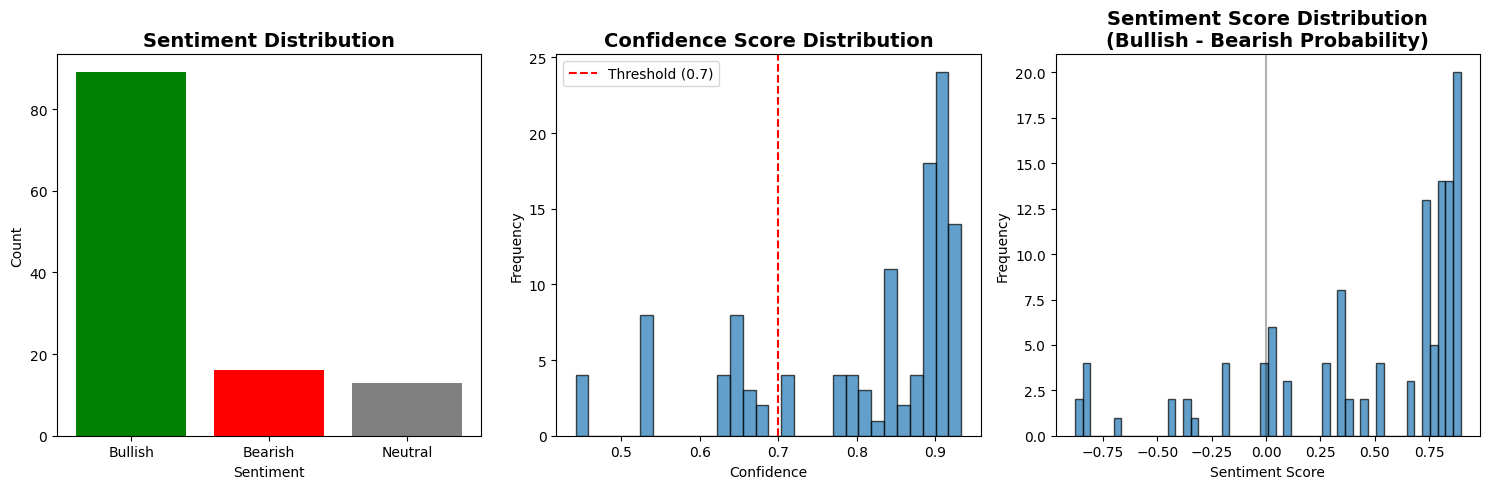

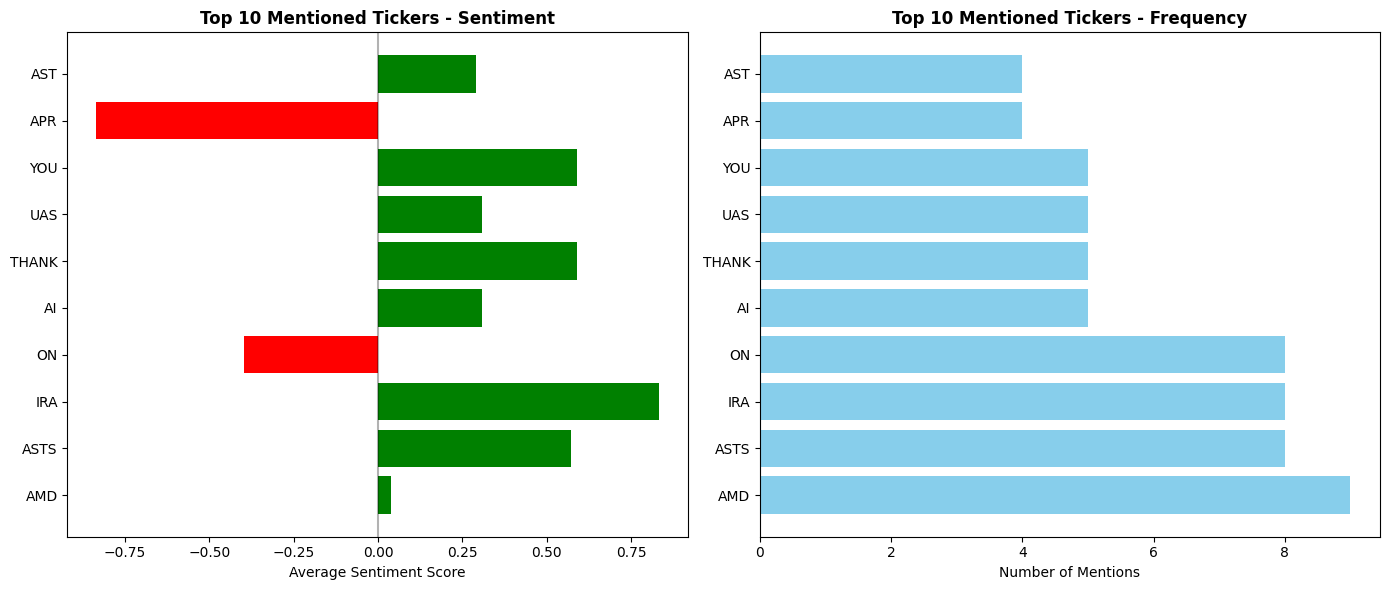


🔥 HIGH-IMPACT POSTS (High confidence + extreme sentiment):

• I’ve 10x’d my “fun” account this year...
  Sentiment: Bullish (score: 0.876)
  Confidence: 0.926, Reddit score: 6230

• I’ve 10x’d my “fun” account this year...
  Sentiment: Bullish (score: 0.876)
  Confidence: 0.926, Reddit score: 6228

• I’ve 10x’d my “fun” account this year...
  Sentiment: Bullish (score: 0.876)
  Confidence: 0.926, Reddit score: 6224

• I’ve 10x’d my “fun” account this year...
  Sentiment: Bullish (score: 0.876)
  Confidence: 0.926, Reddit score: 6223

• JULY U.S. 🇺🇸 INFLATION DATA:...
  Sentiment: Bullish (score: 0.851)
  Confidence: 0.890, Reddit score: 1525

REPORT COMPLETE


In [ ]:
# Example usage and demo with sample data
def create_sample_data():
    """Create sample data for demonstration (when Reddit API is not available)"""
    sample_posts = [
        {"title": "GME TO THE MOON 🚀🚀🚀", "body": "Diamond hands forever! This stock is going up!", 
         "created_utc": datetime.now() - timedelta(days=i), "score": np.random.randint(100, 5000),
         "upvote_ratio": np.random.uniform(0.7, 1.0), "num_comments": np.random.randint(10, 500),
         "author": f"user_{i}", "url": "", "category": "hot"}
        for i in range(100)
    ]
    
    # Add some bearish posts
    bearish_posts = [
        {"title": f"Time to buy puts on {ticker}", "body": "This market is overvalued. Crash incoming!",
         "created_utc": datetime.now() - timedelta(days=i), "score": np.random.randint(50, 2000),
         "upvote_ratio": np.random.uniform(0.6, 0.9), "num_comments": np.random.randint(5, 200),
         "author": f"bear_{i}", "url": "", "category": "new"}
        for i, ticker in enumerate(['SPY', 'QQQ', 'TSLA', 'AAPL'])
    ]
    
    sample_posts.extend(bearish_posts)
    return pd.DataFrame(sample_posts)

def main():
    """Main execution function"""
    print("🚀 WallStreetBets Sentiment Analyzer 🚀")
    print("-" * 40)
    
    # Check if using real Reddit data or sample
    use_reddit = input("Use Reddit API? (y/n, requires API credentials): ").lower() == 'y'
    
    if use_reddit:
        # Initialize pipeline
        pipeline = WSBSentimentPipeline(use_saved_data=False)
        
        # Collect data
        limit = int(input("Number of posts to collect (default 500): ") or 500)
        data = pipeline.collect_data(limit=limit)
    else:
        # Use sample data for demonstration
        print("Using sample data for demonstration...")
        pipeline = WSBSentimentPipeline(use_saved_data=False)
        pipeline.data = create_sample_data()
        
        # Preprocess sample data
        collector = RedditDataCollector("", "", "")
        pipeline.data['cleaned_title'] = pipeline.data['title'].apply(collector.preprocess_wsb_text)
        pipeline.data['cleaned_body'] = pipeline.data['body'].apply(collector.preprocess_wsb_text)
        pipeline.data['combined_text'] = pipeline.data['cleaned_title'] + ' ' + pipeline.data['cleaned_body']
    
    # Analyze sentiment
    print("\nAnalyzing sentiment with FinBERT...")
    pipeline.analyze_sentiment()
    
    # Generate report
    ticker = input("\nEnter stock ticker to compare (e.g., GME, AMC, or press Enter to skip): ").upper()
    pipeline.generate_report(ticker if ticker else None)
    
    # Export results
    export = input("\nExport results to CSV? (y/n): ").lower() == 'y'
    if export:
        filename = f"wsb_sentiment_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        pipeline.data.to_csv(filename, index=False)
        print(f"Results exported to {filename}")

if __name__ == "__main__":
    main()